# Ensemble tuning
This notebook investigates the effect of varying the number of base models in the multi-run ensembles on performance.

We use CASF-2016 as a validation dataset to tune this parameter.

We analyze the following conditions independetly:
* Atom-level
* Surface-level
* Atom/surface-level ensemble

A bootstrapping-like approach is used, whereby for each number of base models, we simulate different runs each of which uses a different subset of the 15 available models. These runs are then used to compute confidence intervals.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

import ensembling
import metrics
import parsing
import postprocessing

# 1. Configuration

In [2]:
# Results paths
AVG_FUN = np.nanmedian  # Reduce function to compute averages across targets. Using nanmedian because there is one target missing from RF/NN-score
EF_ALPHA = 0.01 # alpha for EF metric (i.e., EF1)
BEDROC_ALPHA = 80.5 # alpha for BedROC metric (i.e, BedROC80.5)

TOT_NUM_MODELS = 15  # Total number of models that have been trained for each type of model (atom/surface)
N_RUNS = 20  # How many runs to perform for each number of base models to get confidence intervals (bootstrapping)
SEED = 606  # Random seed to enable reproducible results

DATASET = 'CASF-2016'
PATH_RESULTS = {
    'atom': '../data/outputs/denvis_outputs/core_main_refined_atom.parquet',
    'surface': '../data/outputs/denvis_outputs/core_main_refined_surface.parquet'}

# 2. Parse ressults

In [3]:
results_atom, _ = parsing.parse_results_denvis(path=PATH_RESULTS['atom'])
results_surface, _ = parsing.parse_results_denvis(path=PATH_RESULTS['surface'])

# 3. Performance scores

In [4]:
rng = np.random.default_rng(SEED)  # Ensure reproducible results
results_tf_df = pd.DataFrame(columns=['Model', 'Number of base models', 'Run', 'AUROC', 'EF1', 'BEDROC805'])
for num_models in range(1, TOT_NUM_MODELS + 1):
    for run in range(N_RUNS):
        # Bootstrapping: sample models to use in the ensemble randomly for each run
        which_models = list(rng.choice(range(TOT_NUM_MODELS), size=num_models, replace=False))

        # Atom-level
        res_slice_atom = results_atom[results_atom['version'].isin(which_models)]
        res_slice_atom_ens = ensembling.compute_ensemble_scores(res_slice_atom, ckpt=True, version=True)
        res_slice_atom_ens_out = postprocessing.combine_outputs(res_slice_atom_ens, y_kd_weight=0.5, y_ki_weight=0.5, use_clf=False)
        _, auroc_micro_atom = metrics.compute_auroc_scores(res_slice_atom_ens_out, avg_fun=AVG_FUN)
        _, ef1_micro_atom = metrics.compute_ef_scores(res_slice_atom_ens_out, alpha=EF_ALPHA, avg_fun=AVG_FUN)
        _, bedroc_micro_atom = metrics.compute_bedroc_scores(res_slice_atom_ens_out, alpha=BEDROC_ALPHA, avg_fun=AVG_FUN)

        # Surface-level
        res_slice_surface = results_surface[results_surface['version'].isin(which_models)]
        res_slice_surface_ens = ensembling.compute_ensemble_scores(res_slice_surface, ckpt=True, version=True)
        res_slice_surface_ens_out = postprocessing.combine_outputs(res_slice_surface_ens, y_kd_weight=0.5, y_ki_weight=0.5, use_clf=False)
        _, auroc_micro_surface = metrics.compute_auroc_scores(res_slice_surface_ens_out, avg_fun=AVG_FUN)
        _, ef1_micro_surface = metrics.compute_ef_scores(res_slice_surface_ens_out, alpha=EF_ALPHA, avg_fun=AVG_FUN)
        _, bedroc_micro_surface = metrics.compute_bedroc_scores(res_slice_surface_ens_out, alpha=BEDROC_ALPHA, avg_fun=AVG_FUN)
        
        # Atom/surface-level ensemble
        results_slice_ens_ens = ensembling.compute_level_ensemble_scores(
            res_slice_atom_ens, res_slice_surface_ens, atom_weight=0.5, use_target_intersection=False)
        results_slice_ens_ens_out = postprocessing.combine_outputs(results_slice_ens_ens, y_kd_weight=0.5, y_ki_weight=0.5, use_clf=False)
        _, auroc_micro_ens = metrics.compute_auroc_scores(results_slice_ens_ens_out, avg_fun=AVG_FUN)
        _, ef1_micro_ens = metrics.compute_ef_scores(results_slice_ens_ens_out, alpha=EF_ALPHA, avg_fun=AVG_FUN)
        _, bedroc_micro_ens = metrics.compute_bedroc_scores(results_slice_ens_ens_out, alpha=BEDROC_ALPHA, avg_fun=AVG_FUN)


        # Update dataframe
        new_entries = pd.DataFrame({
            'Model': ['Atom-level', 'Surface-level', 'Level ensemble'],
            'Number of base models': [num_models] * 3,
            'Run': [run] * 3,
            'AUROC': [auroc_micro_atom, auroc_micro_surface, auroc_micro_ens],
            'EF1': [ef1_micro_atom, ef1_micro_surface, ef1_micro_ens],
            'BEDROC805': [bedroc_micro_atom, bedroc_micro_surface, bedroc_micro_ens]
        })
        results_tf_df = pd.concat((results_tf_df, new_entries), axis='index')

results_tf_df = results_tf_df.reset_index()

# 4. Performance vs. number of base models (Figure S2)

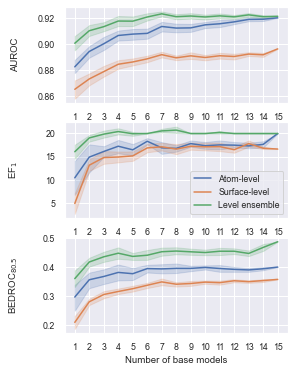

In [5]:
hue_order = ['Atom-level', 'Surface-level', 'Level ensemble']
metrics = ['AUROC', 'EF1', 'BEDROC805']
color_palettte = sns.color_palette(n_colors=len(hue_order))
figsize = (4, 6)
font_scale = 0.8
n_boot = 1000
ci = 95
lw = 1.5

sns.set_context("notebook", font_scale=font_scale)
fig, ax = plt.subplots(figsize=figsize, nrows=3, ncols=1)
for i, metric in enumerate(metrics):
    sns.lineplot(
        data=results_tf_df,
        x='Number of base models',
        y=metric,
        hue='Model',
        ci=ci,
        n_boot=n_boot, ax=ax[i])

# Tidy-up
for ax_ in ax.flatten():
    ax_.set_xticks(range(1, TOT_NUM_MODELS + 1))

for ax_ in ax:
    ax_.set_xlabel('')
    
handles, labels = ax[1].get_legend_handles_labels()
for ax_ in ax.flatten():
    ax_.legend().remove()
ax[1].legend(loc='lower right', handles=handles, labels=labels, bbox_to_anchor=(1.0, 0.))
for ax_ in ax:
    ax_.yaxis.set_label_coords(-0.2, 0.5)
    
ax[2].set_xlabel('Number of base models')
ax[1].set_ylabel(r'EF$_{1}$')
ax[2].set_ylabel(r'BEDROC$_{80.5}$')

plt.show()